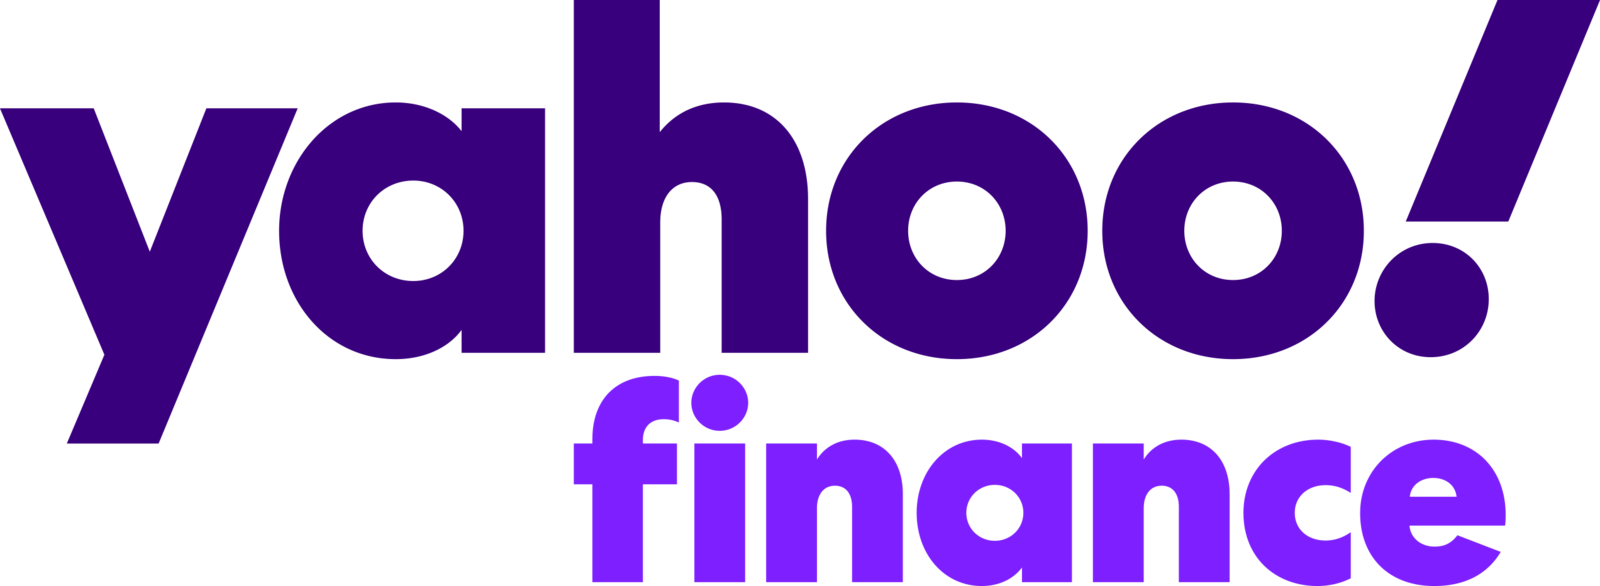

In [27]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import plotly.graph_objects as go
from lightgbm import LGBMRegressor, LGBMClassifier, Booster
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')
import seaborn as sns

In [3]:
df = pd.read_csv("C:/Users/can/Desktop/tuprs.csv")

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-31,127.599998,127.900002,126.300003,126.599998,126.599998,1167391
1,2020-01-02,127.300003,128.899994,126.800003,128.000000,128.000000,1466792
2,2020-01-03,127.599998,127.900002,123.699997,125.699997,125.699997,1992517
3,2020-01-06,123.900002,124.500000,123.300003,123.699997,123.699997,1351452
4,2020-01-07,124.300003,125.300003,122.800003,122.900002,122.900002,2057555


In [5]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe)))
random_noise(df)

array([ 1.80776548e+00, -8.32221073e-01,  2.30518571e+00,  1.22047376e+00,
        3.23058257e-01,  3.56801796e+00, -4.01079509e-01, -3.51134615e+00,
        1.56696248e+00, -8.66969324e-01, -5.12303564e-01,  1.91533011e+00,
        1.35824668e+00, -3.83198759e-01, -2.06487543e+00, -1.20777762e+00,
       -2.59443178e-02,  1.62956644e-01,  1.07582531e+00,  1.15255713e+00,
       -1.54598041e+00, -5.62502001e-01, -5.17774917e-01, -1.91526198e+00,
        5.46795836e-02,  6.93146950e-02,  9.02145623e-01,  1.22867280e+00,
        6.17356170e-01,  2.93414670e+00,  3.37076822e-01, -9.98789022e-01,
       -3.01895616e+00, -1.71715208e+00, -1.87707110e+00,  2.46469222e+00,
       -1.72386340e+00, -1.23475769e+00,  5.89985297e-03, -2.11997669e+00,
        1.37558294e+00,  4.35099037e-01,  1.39597032e+00,  1.01842156e+00,
       -2.38528981e+00,  2.51980585e+00,  1.53532790e+00,  2.11315215e+00,
        1.87605703e-01,  1.35569590e+00, -1.88580719e+00,  1.95673225e-01,
       -4.65222460e-01, -

In [6]:
df["lag1"] = df["Close"].shift(1).values
df["lag2"] = df["Close"].shift(2).values
df["lag5"] = df["Close"].shift(5).values
df["lag14"] = df["Close"].shift(14).values
df["lag21"] = df["Close"].shift(21).values

In [7]:
df["roll1"] = df["Close"].rolling(window=1).mean().values
df["roll2"] = df["Close"].rolling(window=2).mean().values
df["roll14"]= df["Close"].rolling(window=14).mean().values
df["roll21"]= df["Close"].rolling(window=21).mean().values

In [8]:
df["ewm099"] = df["Close"].shift(1).ewm(alpha=0.99).mean().values
df["ewm095"] = df["Close"].shift(1).ewm(alpha=0.95).mean().values
df["ewm085"] = df["Close"].shift(1).ewm(alpha=0.85).mean().values
df["ewm07"] = df["Close"].shift(1).ewm(alpha=0.7).mean().values
df["ewm02"] = df["Close"].shift(1).ewm(alpha=0.1).mean().values

In [9]:
df = pd.get_dummies(df,columns=["Adj Close","Open","High","Low"])

In [10]:
df["Close"] = np.log1p(df["Close"].values)

In [11]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In [12]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [13]:
df["Date"].min(),df["Date"].max() 

('2019-12-31', '2022-12-06')

In [15]:
train = df.loc[(df["Date"]<"2022-09-01"),:]
test = df.loc[(df["Date"]> "2022-09-01"),:]

In [16]:
cols = [col for col in train.columns if col not in ["Close","Date"]]

In [17]:
Y_train = train["Close"]
X_train = train[cols]

Y_test = test["Close"]
X_test = test[cols]

In [18]:
Y_train.shape , X_train.shape , Y_test.shape , X_test.shape

((667,), (667, 2370), (68,), (68, 2370))

In [19]:
lgb_params = {'num_leaves': 7,
              'learning_rate': 0.1,
              'feature_fraction': 1,
              'max_depth': 3,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [20]:
lgbtrain = lgb.Dataset(data=X_train,label=Y_train,feature_name = cols)

lgbval = lgb.Dataset(data=X_test,label=Y_test,reference = lgbtrain ,feature_name = cols)

In [21]:
model = lgb.train(lgb_params,
                  lgbtrain,
                  valid_sets=[lgbtrain,lgbval],
                 num_boost_round = lgb_params["num_boost_round"],
                 early_stopping_rounds = lgb_params["early_stopping_rounds"],
                 feval=lgbm_smape,
                 verbose_eval = 100)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [22]:
y_pred_val = model.predict(X_test,num_iteration = model.best_iteration)

In [23]:
smape(np.expm1(y_pred_val),np.expm1(Y_test))

13.148099043579693

In [24]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance("gain")
    feat_imp = pd.DataFrame({"feature": model.feature_name(),
                             "split": model.feature_importance("split"),
                             "gain": 100 * gain / gain.sum()}).sort_values("gain", ascending=False)

    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title("feature")
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

In [25]:
feat_imp = plot_lgb_importances(model,num=100)

                      feature  split       gain
6                       roll1    286  74.306140
2                        lag2    165  10.376745
7                       roll2    128   8.214426
1                        lag1     84   5.973062
10                     ewm099     77   0.870953
...                       ...    ...        ...
1511               High_142.5      0   0.000000
1512   High_142.6999969482422      0   0.000000
1513  High_146.39999389648438      0   0.000000
1514               High_146.5      0   0.000000
1515               High_148.0      0   0.000000

[100 rows x 3 columns]


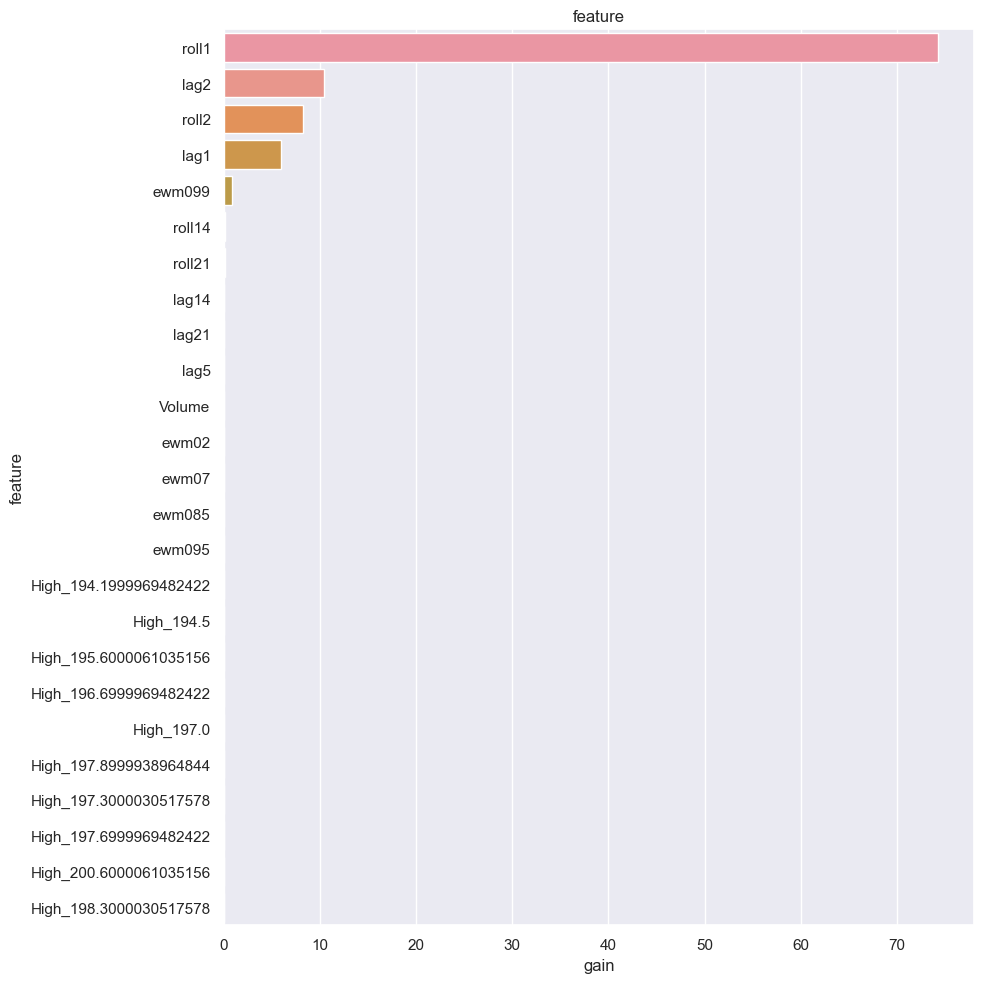

,feature,split,gain
6,roll1,286,74.306140
2,lag2,165,10.376745
7,roll2,128,8.214426
1,lag1,84,5.973062
10,ewm099,77,0.870953
...,...,...,...
798,Open_99.5999984741211,0,0.000000
799,Open_99.6999969482422,0,0.000000
800,Open_99.8000030517578,0,0.000000
801,Open_100.0999984741211,0,0.000000


In [28]:
plot_lgb_importances(model,num=30,plot=True)


In [29]:
train = df.loc[~df.Close.isna()]
Y_train = train["Close"]
X_train = train[cols]
test = df.loc[~df.Close.isna()]
X_test = test[cols]

In [30]:
lgb_params = {'num_leaves': 7,
              'learning_rate': 0.1,
              'feature_fraction': 1,
              'max_depth': 3,
              'verbose': 0,
              'num_boost_round': model.best_iteration,
              'nthread': -1}

In [31]:
lgbtrain_all = lgb.Dataset(data=X_train,label=Y_train,feature_name = cols)

final_model = lgb.train(lgb_params,lgbtrain_all,num_boost_round = model.best_iteration)
test_pred = final_model.predict(X_test,num_iteration=model.best_iteration)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [32]:
submission_df = test.loc[:,["Date","Close"]]


In [33]:
submission_df["Close"] = np.expm1(test_pred)

In [34]:
submission_df


,Date,Close
0,2019-12-31,126.617681
1,2020-01-02,127.939263
2,2020-01-03,125.319841
3,2020-01-06,123.584131
4,2020-01-07,123.248299
...,...,...
731,2022-11-30,480.478817
732,2022-12-01,480.478817
733,2022-12-02,477.880444
734,2022-12-05,479.270312
